# **1. Instalasi library mediapipe**

In [ ]:
pip install opencv-python mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 39.1 MB/s eta 0:00:00


# **2. Inisialisasi dan Impor Modul**


📌 **Fungsi:** Mengimpor pustaka yang diperlukan dan menginisialisasi deteksi tangan dengan MediaPipe.  
📌 **Penjelasan:**
- `cv2` digunakan untuk membaca, menampilkan, dan memproses gambar.
- `mediapipe` digunakan untuk mendeteksi tangan dan titik-titik landmark pada gambar.
- `google.colab.patches.cv2_imshow` digunakan untuk menampilkan gambar di Google Colab.
- `mp.solutions.hands` digunakan untuk inisialisasi model deteksi tangan.
- `mp_draw.draw_landmarks` digunakan untuk menggambar titik-titik landmark tangan.


In [ ]:
import cv2
import mediapipe as mp
from google.colab.patches import cv2_imshow  # Impor untuk menampilkan gambar di Google Colab

# Inisialisasi MediaPipe untuk deteksi tangan
mp_hands = mp.solutions.hands
hands = mp_hands.Hands()
mp_draw = mp.solutions.drawing_utils


# **3. Fungsi untuk Menghitung Jumlah Jari Terangkat**

📌 **Fungsi:** Menganalisis gambar dan menghitung jumlah jari yang terangkat.  
📌 **Penjelasan:**
1. Gambar dikonversi ke format RGB agar sesuai dengan MediaPipe.
2. MediaPipe memproses gambar untuk mendeteksi tangan dan titik landmark.
3. Mengevaluasi posisi jari-jari berdasarkan **titik ujung** (finger tips) dan **titik dasar** (finger bases).
4. Jari dianggap **terangkat** jika koordinat `y` dari ujung jari lebih kecil dari dasar jari.
5. Mengembalikan jumlah jari yang terangkat.

In [ ]:
def count_raised_fingers(image):
    # Mengubah gambar menjadi RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Proses gambar untuk deteksi tangan
    result = hands.process(image_rgb)

    if result.multi_hand_landmarks:
        for hand_landmarks in result.multi_hand_landmarks:
            # Menggambar titik tangan
            mp_draw.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            # Cek posisi jari-jari untuk menentukan yang terangkat
            raised_fingers = 0

            # Indeks jari dan posisi titik tangan
            finger_tips = [8, 12, 16, 20]  # Titik-titik ujung jari
            finger_bases = [5, 9, 13, 17]  # Titik dasar jari

            # Loop untuk masing-masing jari
            for tip, base in zip(finger_tips, finger_bases):
                # Mendapatkan posisi titik pada gambar
                tip_y = hand_landmarks.landmark[tip].y
                base_y = hand_landmarks.landmark[base].y

                # Menentukan jari terangkat jika posisi ujung lebih tinggi dari dasar
                if tip_y < base_y:  # Cek apakah ujung jari lebih tinggi dari dasar
                    raised_fingers += 1

            return raised_fingers
    return 0  # Jika tidak ada tangan terdeteksi, anggap 0 jari terangkat


# **4. Fungsi untuk Deteksi Tepi (Canny Edge Detection)**


📌 **Fungsi:** Mendeteksi tepi objek pada gambar menggunakan metode **Canny Edge Detection**.  
📌 **Penjelasan:**
1. Gambar dikonversi ke grayscale untuk menyederhanakan pemrosesan.
2. `cv2.Canny()` diterapkan dengan threshold **100** (bawah) dan **200** (atas).
3. Menghasilkan gambar hitam-putih yang menyoroti tepi objek dalam gambar.

In [ ]:
def apply_canny_edge_detection(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_image, 100, 200)
    return edges


# **5. Fungsi untuk Menghitung Akurasi**

📌 **Fungsi:** Menghitung akurasi sistem dalam mendeteksi jumlah jari yang benar.  
📌 **Penjelasan:**
1. Jika jumlah jari sebenarnya `actual_fingers = 0`, maka akurasi 100% jika prediksi juga 0.
2. Jika ada kesalahan prediksi, akurasi dihitung menggunakan rumus:
   \[
   \text{Akurasi} = \left(1 - \frac{| \text{predicted} - \text{actual} |}{\text{actual}} \right) \times 100
   \]
3. Pastikan nilai akurasi minimal 0% (tidak negatif).

In [ ]:
def calculate_accuracy(predicted, actual):
    if actual == 0:
        return 100.0 if predicted == 0 else 0.0
    accuracy = (1 - abs(predicted - actual) / actual) * 100
    return max(0, accuracy)  # Pastikan akurasi tidak negatif


# **6. Fungsi untuk Menampilkan Gambar dan Menghitung Akurasi**

📌 **Fungsi:** Menampilkan gambar, jumlah jari yang terdeteksi, dan akurasi prediksi.  
📌 **Penjelasan:**
1. Membaca gambar dari `image_path`.
2. Memanggil `count_raised_fingers()` untuk menghitung jumlah jari terangkat.
3. Menghitung akurasi menggunakan `calculate_accuracy()`.
4. Menampilkan teks jumlah jari dan akurasi pada gambar dengan `cv2.putText()`.
5. Menampilkan hasil deteksi tepi menggunakan `apply_canny_edge_detection()`.
6. Menampilkan semua informasi di layar dan mencetak hasil ke terminal.


In [ ]:
def display_image_with_fingers_count_and_accuracy(image_path, actual_fingers):
    image = cv2.imread(image_path)
    predicted_fingers = count_raised_fingers(image)

    # Hitung akurasi
    accuracy = calculate_accuracy(predicted_fingers, actual_fingers)

    # Tambahkan teks jumlah jari dan akurasi pada gambar
    cv2.putText(image, f"Detected: {predicted_fingers} fingers", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(image, f"Accuracy: {accuracy:.2f}%", (10, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)

    # Menampilkan gambar asli
    print("Gambar Asli:")
    cv2_imshow(image)

    # Menampilkan hasil deteksi tepi
    edges = apply_canny_edge_detection(image)
    print("Hasil Deteksi Tepi (Canny):")
    cv2_imshow(edges)

    print(f"Jumlah Jari Sebenarnya: {actual_fingers}")
    print(f"Jumlah Jari Terdeteksi: {predicted_fingers}")
    print(f"Akurasi: {accuracy:.2f}%")

    cv2.waitKey(0)
    cv2.destroyAllWindows()


# **7. Eksekusi Program Utama**

📌 **Fungsi:** Menghubungkan semua fungsi dalam satu pipeline.  
📌 **Penjelasan:**
1. **Mengimpor modul** dari masing-masing file.
2. **Menentukan path gambar** yang akan diproses.
3. **Menentukan jumlah jari sebenarnya** dalam gambar.
4. **Menjalankan `display_image_with_fingers_count_and_accuracy()`**, yang:
   - Menghitung jumlah jari.
   - Menghitung akurasi prediksi.
   - Menampilkan hasil dan gambar.

Gambar Asli:


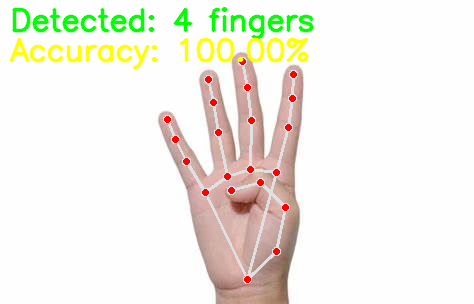

Hasil Deteksi Tepi (Canny):


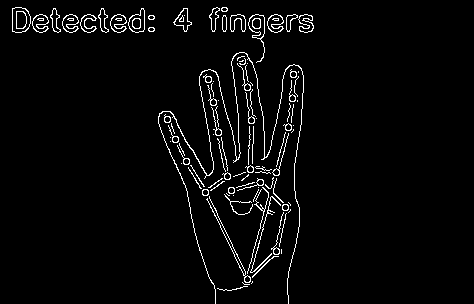

Jumlah Jari Sebenarnya: 4
Jumlah Jari Terdeteksi: 4
Akurasi: 100.00%


In [ ]:
# Import semua modul yang telah dipisah
import cv2
import mediapipe as mp
from google.colab.patches import cv2_imshow
from google.colab import files

# Ganti dengan path gambar dan jumlah jari sebenarnya
image_path = '/content/empat (1).jpg'
actual_fingers = 4  # Sesuaikan dengan jumlah jari yang benar dalam gambar

display_image_with_fingers_count_and_accuracy(image_path, actual_fingers)
